In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [36]:
import glob
import os
import pickle

if 1:
    #df = pd.read_csv('./metrics/fewshot/060321-020115_STL10_metrics.csv')
    df = pd.read_csv('./metrics/fewshot/060321-015613_CIFAR10_metrics.csv')
    pkl = './metrics/fewshot/060321-015613_CIFAR10_pr.pkl'
    with open(pkl, 'rb') as f:
        pr = pickle.load(f)

    
    """
    df1 = pd.read_csv('./metrics/latest/060221-234441_CIFAR10_metrics.csv')
    df2 = pd.read_csv('./metrics/latest/060321-001129_SVHN_metrics.csv')
    df3 = pd.read_csv('./metrics/latest/060221-235053_STL10_metrics.csv')
    """
    
       
elif os.environ.get('USER') == 'acganesh':
    metrics_path = './metrics/latest'
    _id = '060221-221129_CIFAR10_'
    
    csv = glob.glob(f'{metrics_path}/{_id}*.csv')[0]
    pkl = glob.glob(f'{metrics_path}/{_id}*.pkl')[0]
    
    print(csv)
    print(pkl)
    df = pd.read_csv(csv)
    with open(pkl, 'rb') as f:
        pr = pickle.load(f)
else:
    # df_cifar = pd.read_csv("../../RESULTS/060221-073204_CIFAR10_metrics.csv")
    # df_svhn = pd.read_csv("../../RESULTS/060221-051821_SVHN_metrics.csv")
    df_cifar = pd.read_csv("../../REALRESULTS/060221-221129_CIFAR10_metrics.csv")
    df_svhn = pd.read_csv("../../REALRESULTS/060221-223821_SVHN_metrics.csv")

In [27]:
sample_types = np.array(['rand', 'kmeans', 'loss_based_mean', 'loss_based_std',
       'grad_based_mean', 'grad_based_std'])


percentages = 100 * np.array([0.0025, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1])
#percentages = np.arange(5, 99)

In [13]:
# Mask 1 is which sample_types you want from df 1
def merge_dfs(df1, df2, mask_1):
    mask = np.array(mask_1)
    df1_masked = df1[df1["sampler_type"].isin(mask)]
    df2_masked = df2[~df2["sampler_type"].isin(mask)]
    df_final = pd.concat([df1_masked,df2_masked])
    return df_final
    

In [30]:
def get_rankings(scores, num): # first num percentages to rank
    total_rankings = defaultdict(int)
    for index, percentage in enumerate(percentages[:num]):
        names = sorted(scores.items(), key=lambda item: item[1][index], reverse=True)
        ranking = [names[0][0], names[1][0], names[2][0], names[3][0], names[4][0], names[5][0]]
        
        for rank, name in enumerate(ranking):
            total_rankings[name] = total_rankings[name] + (rank + 1)
        
    for key, value in total_rankings.items():
        print(key, value / num) # divide by total
        


def plot_metrics(df_full, ds, num_to_rank=5):
    df = df_full.groupby(["ds_type", "sampler_type", "num_examples"]).mean().reset_index()
    plt.figure()
    scores = {}
    for sample_type in df["sampler_type"].unique():
        num_examples = df[df.sampler_type == sample_type]["num_examples"].tolist()
        lr_acc = df[df.sampler_type == sample_type]["lr_byol_acc"].tolist()
        scores[sample_type] = lr_acc
        plt.scatter(np.arange(len(num_examples)), lr_acc, label=sample_type)

    get_rankings(scores, num_to_rank)
        
    plt.legend()
    #plt.xticks(np.arange(len(percentages)), percentages)
    plt.title("Top-1 Acc {}".format(ds))
    plt.show()
    
    scores = {}
    plt.figure()
    for sample_type in df["sampler_type"].unique():
        num_examples = df[df.sampler_type == sample_type]["num_examples"].tolist()
        lr_acc = df[df.sampler_type == sample_type]["lr_byol_top3_acc"].tolist()
        scores[sample_type] = lr_acc
        plt.scatter(np.arange(len(num_examples)), lr_acc, label=sample_type)

    get_rankings(scores, num_to_rank)
    
    plt.legend()
    #plt.xticks(np.arange(len(percentages)), percentages)
    plt.title("Top-3 Acc {}".format(ds))
    plt.show()
    
def plot_pr_curves(prs, n):
    from sklearn.metrics import precision_recall_curve
    
    for pr in prs[:n]:
        title = f"{pr['sampler_type']}_{pr['ds_type']}_{pr['num_examples']}examples"
        curve = pr['lr_byol_pr']
        for i in range(10):
            recall = curve['recall']
            precision = curve['precision']
            plt.plot(recall[i], precision[i], lw=2, label=f'class {i}')

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc='best')
        plt.title(title)
        plt.show()
        
        
def plot_aps(prs, ds_type):
    for pr in prs:
        title = f"{pr['sampler_type']}_{pr['ds_type']}_{pr['num_examples']}examples"
        
        if pr['ds_type'] != ds_type:
            continue
            
        pr_data = pr['lr_byol_pr']

        
        ap = pr_data['average_precision']
        
        for i in range(10):
            plt.scatter(i, ap[i], label=f'class_{i}')
        
        plt.legend(loc='best')
        plt.ylabel('AP')
        plt.xlabel('Class idx')
        
        plt.show()
        plt.title(title)
        
def plot_macro_ap(prs):
    groups = defaultdict(list)
    for pr in prs:
        title = f"{pr['sampler_type']}_{pr['ds_type']}_{pr['num_examples']}examples"            
        pr_data = pr['lr_byol_pr']

        
        ap = pr_data['average_precision']
        ap_lst = [ap[i] for i in range(10)]
        macro_ap = np.mean(ap_lst)
        
        stype = pr['sampler_type']
        groups[stype].append((pr['num_examples'], macro_ap))
        
    for k, metrics in groups.items():
        x, y = zip(*metrics)
        plt.scatter(np.array(x).astype('str'), y, label=k)
        
    
    plt.ylabel('Macro averaged AP')
    plt.xlabel('Number of examples')
    #plt.xscale('log')
    plt.legend(loc=(1.04,0))
    #plt.xticks(np.arange(len(percentages)), percentages)
    #plt.xticks(rotation=45)



    plt.show()
    
def plot_class_ap(prs, class_id):
    groups = defaultdict(list)

    for pr in prs:
        title = f"{pr['sampler_type']}_{pr['ds_type']}_{pr['num_examples']}examples"            
        pr_data = pr['lr_byol_pr']
        ap = pr_data['average_precision']
        ap_cls = ap[class_id]
        stype = pr['sampler_type']
        groups[stype].append((pr['num_examples'], ap_cls))
        
                
    for k, metrics in groups.items():
        x, y = zip(*metrics)
        plt.scatter(np.array(x).astype('str'), y, label=k)
        
    #plt.xticks(np.arange(len(percentages)), percentages)
    #plt.xticks(rotation=45)
    
    plt.ylabel(f'Class  AP: class_{class_id}')
    plt.xlabel('Number of examples')
    plt.legend(loc=(1.04,0))

    plt.show()


grad_based_std 2.8
loss_based_std 2.6
grad_based_mean 4.8
rand 2.0
loss_based_mean 5.4
kmeans 3.4


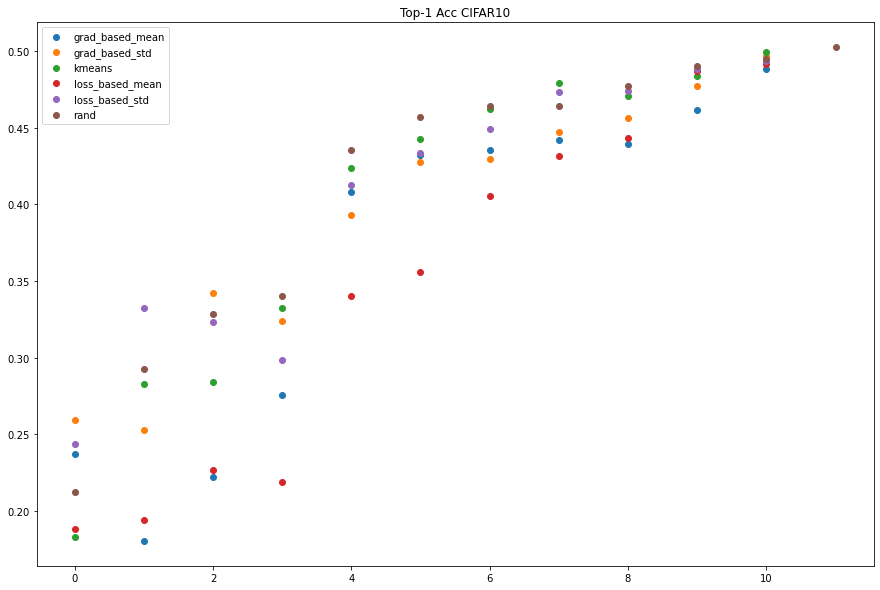

grad_based_mean 4.4
loss_based_std 3.0
rand 1.8
grad_based_std 2.8
kmeans 3.4
loss_based_mean 5.6


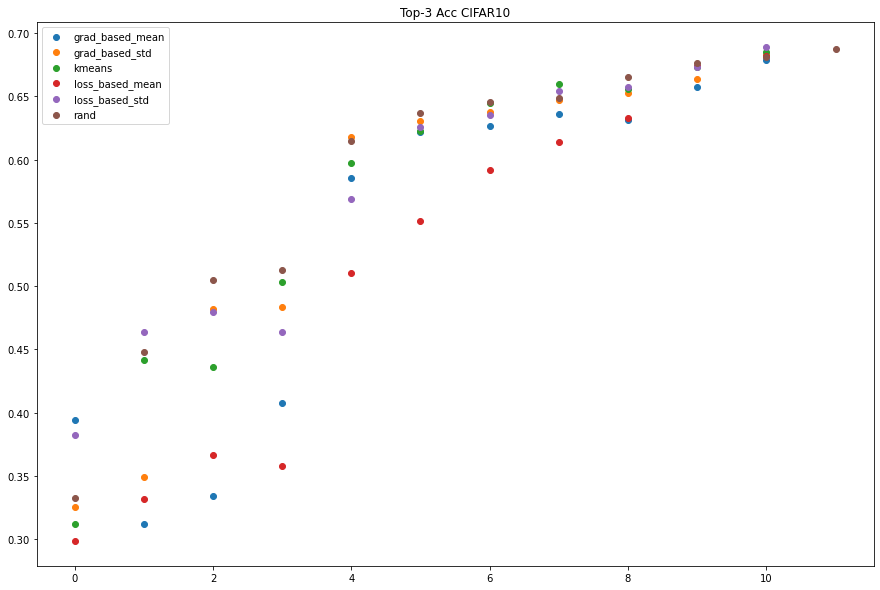

grad_based_std 3.2
loss_based_std 2.6
grad_based_mean 4.2
kmeans 3.6
rand 2.2
loss_based_mean 5.2


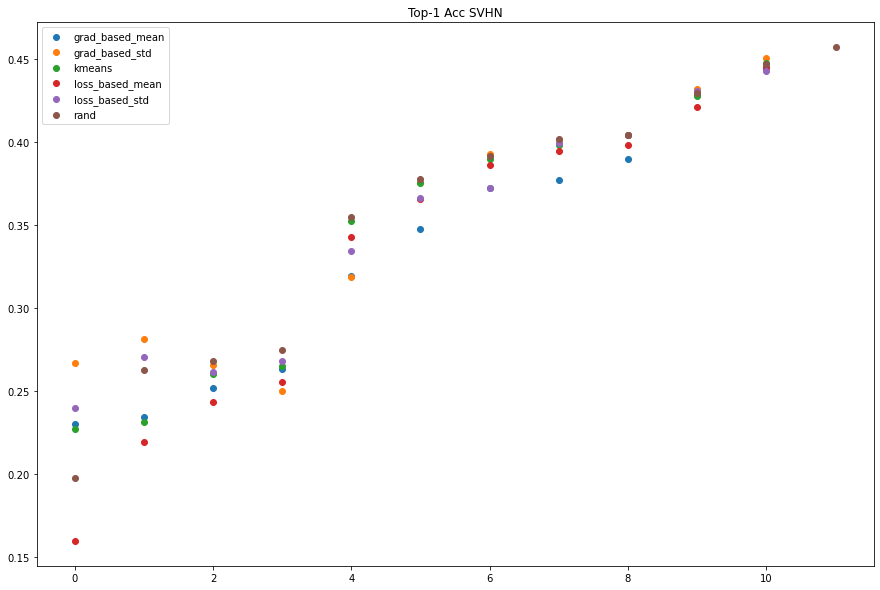

grad_based_std 3.0
loss_based_std 3.2
kmeans 2.6
rand 1.8
grad_based_mean 5.0
loss_based_mean 5.4


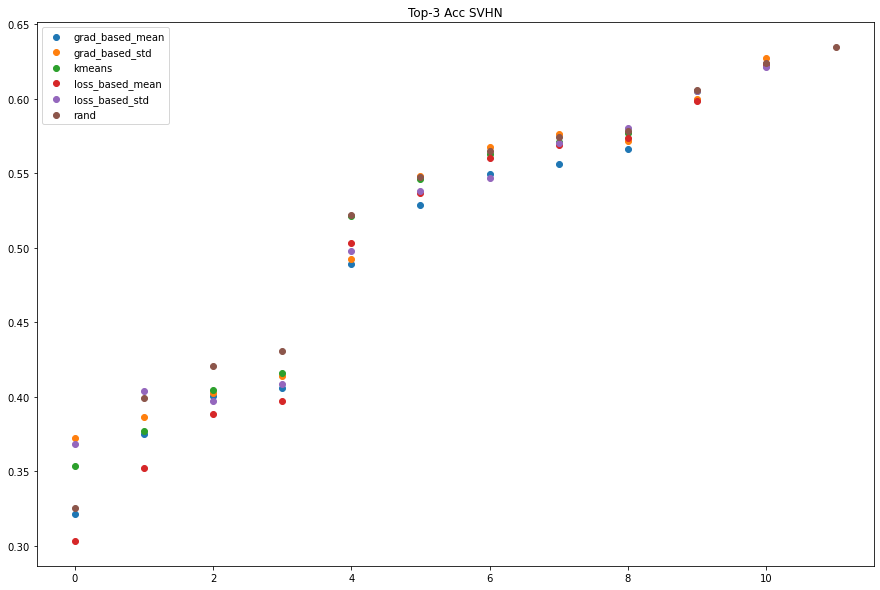

rand 2.4
kmeans 3.2
grad_based_std 4.0
loss_based_std 1.8
grad_based_mean 3.6
loss_based_mean 6.0


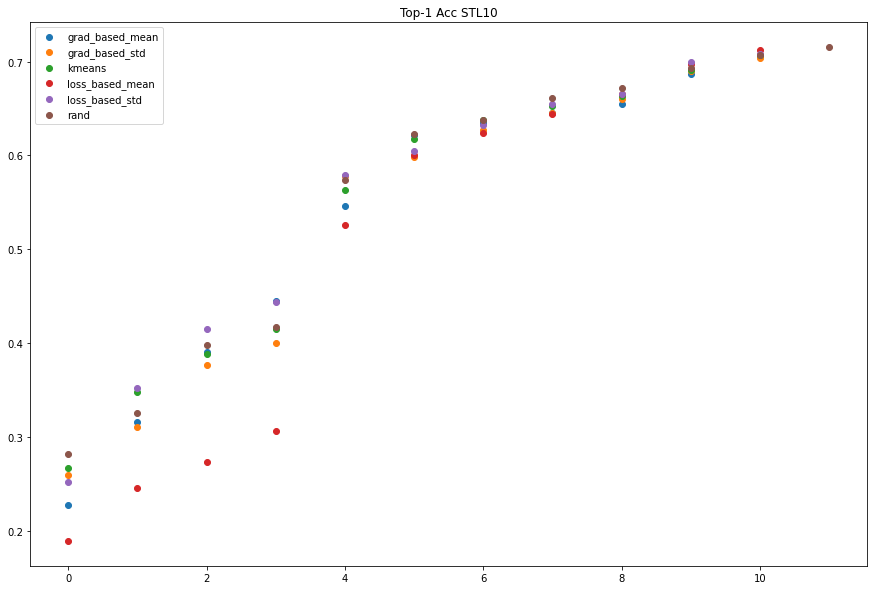

rand 1.8
loss_based_std 2.2
kmeans 3.2
grad_based_std 4.0
grad_based_mean 4.0
loss_based_mean 5.8


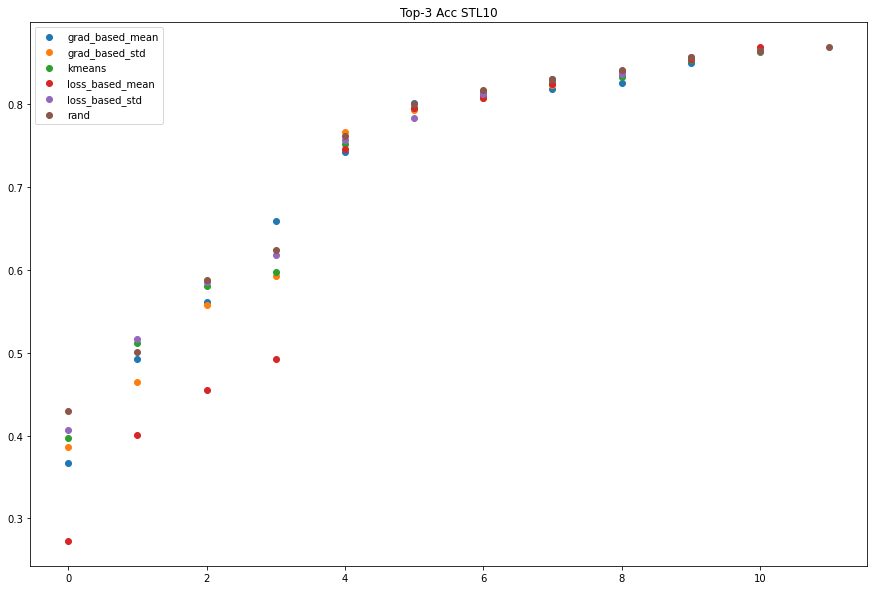

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

plot_metrics(df1, 'CIFAR10')
plot_metrics(df2, 'SVHN')
plot_metrics(df3, 'STL10')

In [15]:
print(pr[0].keys())

pr[0]['lr_byol_pr']['average_precision']

plot_aps(pr, ds_type='SVHN')

dict_keys(['lr_byol_pr', 'sampler_type', 'ds_type', 'num_examples'])


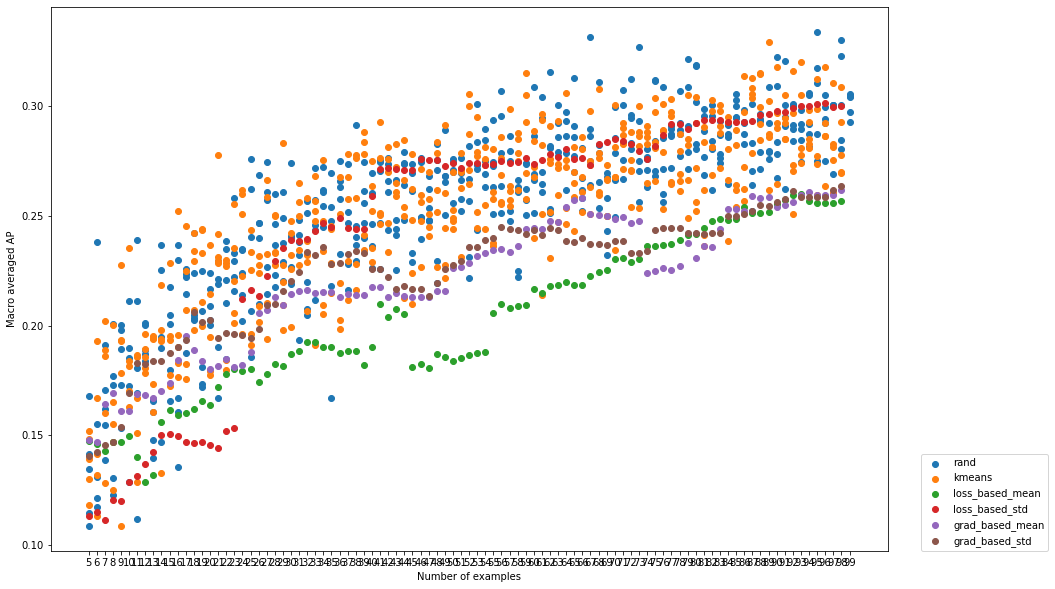

In [16]:
plot_macro_ap(pr)

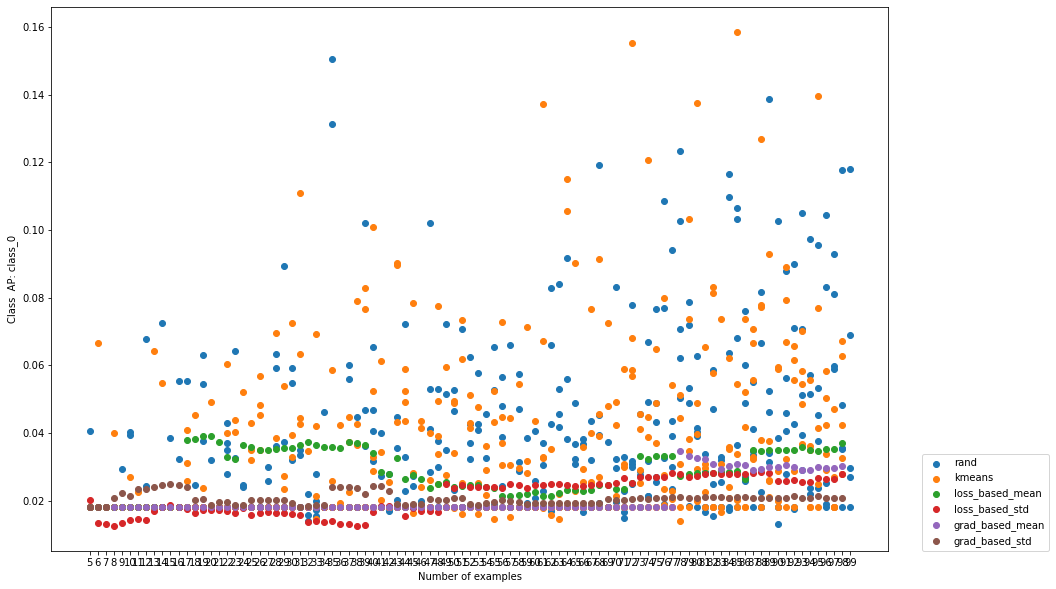

In [22]:
plot_class_ap(pr, 0)

grad_based_mean 1.2
grad_based_std 2.8
loss_based_mean 5.2
loss_based_std 4.4
kmeans 4.0
rand 3.4


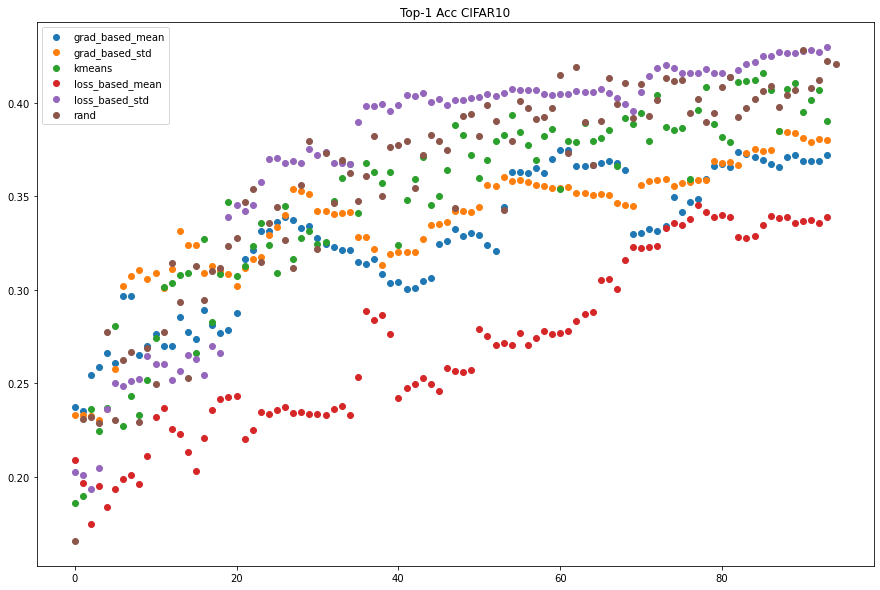

grad_based_mean 1.2
grad_based_std 2.8
loss_based_mean 5.0
kmeans 3.8
loss_based_std 5.4
rand 2.8


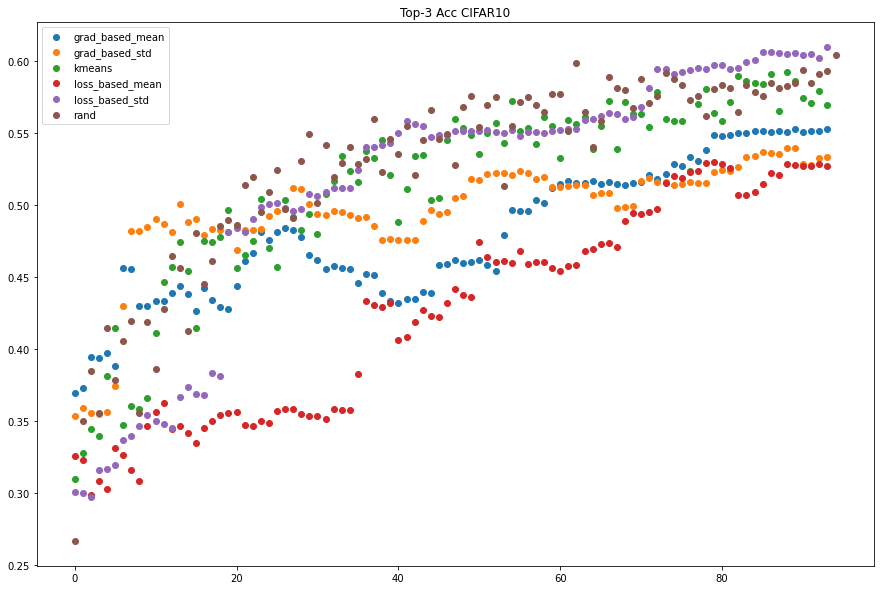

In [37]:
plot_metrics(df, 'CIFAR10')